In [1]:
# Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

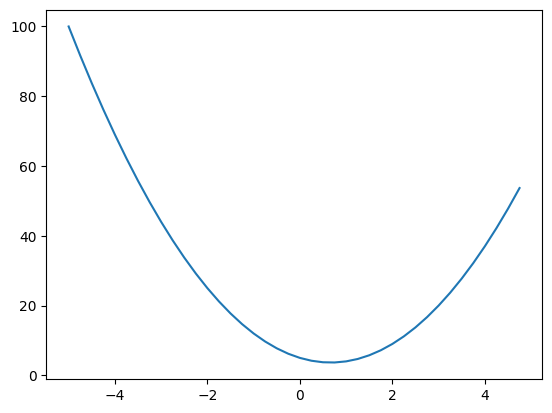

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [4]:
# Calculating derivative of f(x)
h = 0.0000001
x = 3.0
(f(x + h) - f(x)) / h

14.000000305713911

In [5]:
# More complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [6]:
h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [7]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out  

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**other')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    # Backward
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                #print(f'{v.label}: Append visited')
                visited.add(v)
                for child in v._prev:
                    #print(f'{child.label}: build_topo()')
                    build_topo(child)
                #print(f'{v.label}: Append topo')
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

    def __neg__(self): # -self
        return self * -1  
        
    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}"

In [8]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')
a - b

Value(data=-2.0, grad=0

In [9]:
from graphviz import Digraph

def trace(root):
    # Builds set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any node in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is the result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to rhe op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [10]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

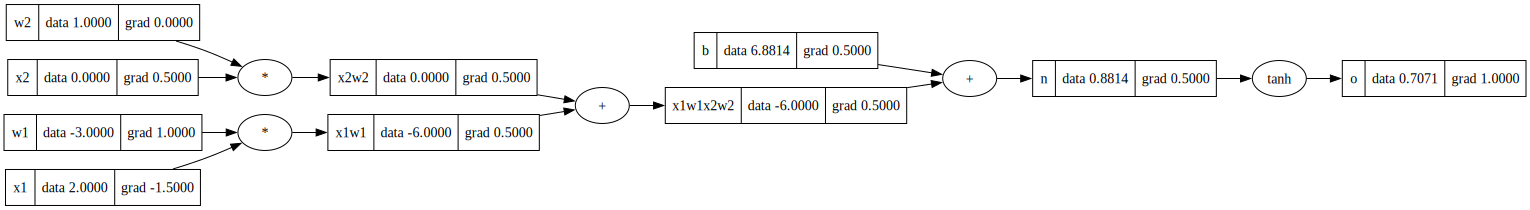

In [11]:
draw_dot(o)

In [12]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#-------
e = (2*n).exp()
o = (e - 1) / (e + 1)
#-------
o.label = 'o'
o.backward()

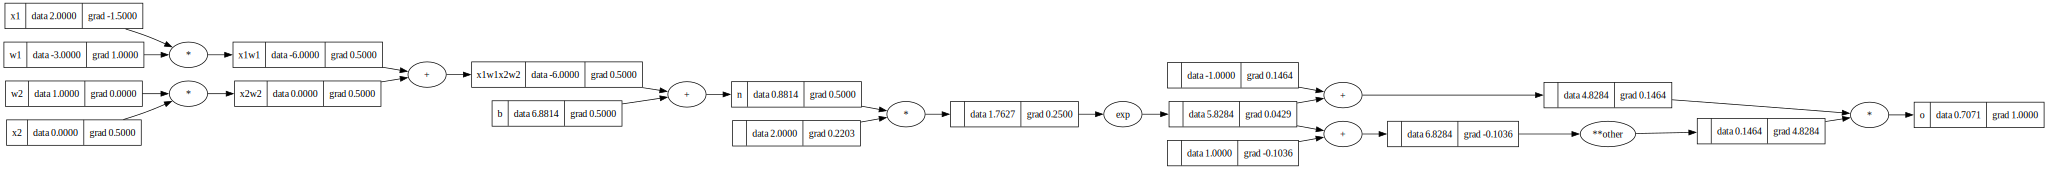

In [13]:
draw_dot(o)

In [35]:
class Neuron:
    
    def __init__(self, nin):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.bias = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.weights, x)), self.bias)
        out = act.tanh()
        return out

    def parameters(self):
        return self.weights + [self.bias]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = []
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [73]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6825784996269859, grad=0

In [74]:
xs = [
    [2,0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # Desired targets

In [75]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.231776055226449, grad=0

In [108]:
for k in range(20):

    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Adjust parameters
    for p in n.parameters():
        p.data += -0.2 * p.grad

    print(k, loss.data)

0 0.00019329437108579498
1 0.0001931955025021632
2 0.00019309673207590692
3 0.00019299805966269758
4 0.00019289948511849435
5 0.00019280100829953094
6 0.00019270262906232203
7 0.00019260434726365745
8 0.00019250616276061608
9 0.0001924080754105467
10 0.00019231008507107538
11 0.00019221219160010485
12 0.0001921143948558078
13 0.00019201669469664164
14 0.00019191909098133255
15 0.0001918215835688798
16 0.00019172417231855927
17 0.0001916268570899204
18 0.0001915296377427692
19 0.00019143251413720143


In [109]:
ypred

[Value(data=0.9924035676369054, grad=-0.015192864726189192,
 Value(data=-0.9950780276470982, grad=0.009843944705803631,
 Value(data=-0.9924390083599053, grad=0.015121983280189433,
 Value(data=0.9927658916882716, grad=-0.014468216623456875]